In [66]:
!python3 Datasets/audio_utils.py Datasets/datasets.py models/models.py

In [1]:
import os
import sys
import librosa
import numpy as np
import pandas as pd
import torch

sys.path.append('Datasets/')
sys.path.append('models/')
import datasets
import models
import audio_utils

In [3]:
class LogMelExtractor(object):
    def __init__(self, sample_rate, window_size, hop_size, mel_bins, fmin, fmax):
        '''Log mel feature extractor. 
        
        Args:
          sample_rate: int
          window_size: int
          hop_size: int
          mel_bins: int
          fmin: int, minimum frequency of mel filter banks
          fmax: int, maximum frequency of mel filter banks
        '''
        
        self.window_size = window_size
        self.hop_size = hop_size
        self.window_func = np.hanning(window_size)
        
        self.melW = librosa.filters.mel(
            sr=sample_rate, 
            n_fft=window_size, 
            n_mels=mel_bins, 
            fmin=fmin, 
            fmax=fmax).T
        '''(n_fft // 2 + 1, mel_bins)'''

    def transform(self, audio):
        '''Extract feature of a singlechannel audio file. 
        
        Args:
          audio: (samples,)
          
        Returns:
          feature: (frames_num, freq_bins)
        '''
    
        window_size = self.window_size
        hop_size = self.hop_size
        window_func = self.window_func
        
        # Compute short-time Fourier transform
        stft_matrix = librosa.core.stft(
            y=audio, 
            n_fft=window_size, 
            hop_length=hop_size, 
            window=window_func, 
            center=True, 
            dtype=np.complex64, 
            pad_mode='reflect').T
        '''(N, n_fft // 2 + 1)'''
    
        # Mel spectrogram
        mel_spectrogram = np.dot(np.abs(stft_matrix) ** 2, self.melW)
        
        # Log mel spectrogram
        logmel_spectrogram = librosa.core.power_to_db(
            mel_spectrogram, ref=1.0, amin=1e-10, 
            top_db=None)
        
        logmel_spectrogram = logmel_spectrogram.astype(np.float32)
        
        return logmel_spectrogram

In [4]:
# Feature extractor
feature_extractor = LogMelExtractor(
    sample_rate=32000, 
    window_size=1024, 
    hop_size=500, 
    mel_bins=64, 
    fmin=50, 
    fmax=14000)

In [2]:
SAMPLE_RATE = 32000
WINDOW_SIZE = 1024
HOP_SIZE = 500
MEL_BINS = 64
FMIN = 50
FMAX = 14000

def get_log_melSpectrogram(audio):
    mel_spectrogram = librosa.feature.melspectrogram(
        y=audio, sr=SAMPLE_RATE,
        n_mels = MEL_BINS,
        hop_length = HOP_SIZE,
        n_fft = WINDOW_SIZE
    )

    log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

    return log_mel_spectrogram

def read_audio(path):
    """read audio, no transformation"""
    y, sr = librosa.load(path, sr=SAMPLE_RATE, mono=True)

    if y.ndim > 1:
        y = librosa.to_mono(y.T)
    
    if sr != SAMPLE_RATE:
        y = librosa.resample(y, orig_sr=sr, target_sr=SAMPLE_RATE)
    
    return y

def pad_truncate_sequence(x, max_len):
    if len(x) < max_len:
        return np.concatenate((x, np.zeros(max_len - len(x))))
    else:
        return x[0 : max_len]
    
# converting input feature shape according to what our model takes
def convert_input_feature(feature):
    # Feature has to be transformed into x = input[None, :, :] where input is your feature from the audio
    x = feature[None, :, :]
    #print("Shape of input feature : ", x.shape)
    mean = np.mean(x)
    std = np.std(x)
    
    # Normalizing the tensor 
    #print("Mean of x: ", mean, "\nStd of x:", std)
    x = (x - mean) / std
    
    tensor_x = torch.from_numpy(x)
    #print("Shape of tensor : ",tensor_x.shape)
    tensor_x = tensor_x.to(device='cuda:1')
    
    return tensor_x
    
# extract features from audio
def get_features(audio_path):
    # Read audio
    audio = read_audio(audio_path)
    
     # Pad or truncate audio recording to the same length
    audio = pad_truncate_sequence(audio, 320000) #320000 is total_samples = sample_rate * audio_duration
    
    # Extract feature
    #logmel_spectrogram = feature_extractor.transform(audio)
    logmel_spectrogram = get_log_melSpectrogram(audio)
    
    # Remove the extra log mel spectrogram frames caused by padding zero
    feature = logmel_spectrogram[0 : 640]
    feature = feature.astype(np.float32)

    #return convert_input_feature(feature)
    return (feature)


In [6]:
import torch.nn as nn
import torch.nn.functional as F

def init_layer(layer, nonlinearity='leaky_relu'):
    """Initialize a Linear or Convolutional layer. """
    nn.init.kaiming_uniform_(layer.weight, nonlinearity=nonlinearity)

    if hasattr(layer, 'bias'):
        if layer.bias is not None:
            layer.bias.data.fill_(0.)
    
    
def init_bn(bn):
    """Initialize a Batchnorm layer. """
    
    bn.bias.data.fill_(0.)
    bn.running_mean.data.fill_(0.)
    bn.weight.data.fill_(1.)
    bn.running_var.data.fill_(1.)

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        
        super(ConvBlock, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=in_channels, 
                              out_channels=out_channels,
                              kernel_size=(3, 3), stride=(1, 1),
                              padding=(1, 1), bias=False)
                              
        self.conv2 = nn.Conv2d(in_channels=out_channels, 
                              out_channels=out_channels,
                              kernel_size=(3, 3), stride=(1, 1),
                              padding=(1, 1), bias=False)
                              
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.init_weights()
        
    def init_weights(self):
        
        init_layer(self.conv1)
        init_layer(self.conv2)
        init_bn(self.bn1)
        init_bn(self.bn2)
        
    def forward(self, input, pool_size=(2, 2), pool_type='avg'):
        
        x = input
        x = F.relu_(self.bn1(self.conv1(x)))
        x = F.relu_(self.bn2(self.conv2(x)))
        if pool_type == 'max':
            x = F.max_pool2d(x, kernel_size=pool_size)
        elif pool_type == 'avg':
            x = F.avg_pool2d(x, kernel_size=pool_size)
        else:
            raise Exception('Incorrect argument!')
        
        return x
    
    
class Cnn_9layers_AvgPooling(nn.Module):
    
    def __init__(self, classes_num, activation):
        super(Cnn_9layers_AvgPooling, self).__init__()

        self.activation = activation

        self.conv_block1 = ConvBlock(in_channels=1, out_channels=64)
        self.conv_block2 = ConvBlock(in_channels=64, out_channels=128)
        self.conv_block3 = ConvBlock(in_channels=128, out_channels=256)
        self.conv_block4 = ConvBlock(in_channels=256, out_channels=512)

        self.fc = nn.Linear(512, classes_num, bias=True)

        self.init_weights()

    def init_weights(self):

        init_layer(self.fc)

    def forward(self, input):
        '''
        Input: (batch_size, times_steps, freq_bins)'''
        
        x = input[:, None, :, :]
        '''(batch_size, 1, times_steps, freq_bins)'''
        
        x = self.conv_block1(x, pool_size=(2, 2), pool_type='avg')
        x = self.conv_block2(x, pool_size=(2, 2), pool_type='avg')
        x = self.conv_block3(x, pool_size=(2, 2), pool_type='avg')
        x = self.conv_block4(x, pool_size=(1, 1), pool_type='avg')
        '''(batch_size, feature_maps, time_steps, freq_bins)'''
        
        x = torch.mean(x, dim=3)        # (batch_size, feature_maps, time_stpes)
        (x, _) = torch.max(x, dim=2)    # (batch_size, feature_maps)
        x = self.fc(x)
        
        if self.activation == 'logsoftmax':
            output = F.log_softmax(x, dim=-1)
            
        elif self.activation == 'sigmoid':
            output = torch.sigmoid(x)
        
        return output

In [32]:
model = Cnn_9layers_AvgPooling(classes_num=10, activation='logsoftmax')
#checkpoint = torch.load('/work/aistwal/dcase2019_task1/checkpoints/main/logmel_64frames_64melbins/TAU-urban-acoustic-scenes-2019-development/holdout_fold=1/Cnn_9layers_AvgPooling/5000_iterations.pth')
#checkpoint = torch.load('/work/aistwal/MMDS_MasterThesis/models/checkpoints/tau_2019_conv_10_16.pth')
state_ = torch.load('ASC_scapper_Cnn9_64mel_10epochs.pt')
model.load_state_dict(state_)
model

Cnn_9layers_AvgPooling(
  (conv_block1): ConvBlock(
    (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_block2): ConvBlock(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_block3): ConvBlock(
    (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1

In [33]:
device = 'cuda:1' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

def make_preds(inputs):
    model.eval()
    with torch.inference_mode():    
        output = (model((inputs).to(device)))

    return (np.argmax(torch.sigmoid(output.cpu()).numpy()))

In [40]:
labels = ['airport', 'shopping_mall', 'metro_station', 'street_pedestrian','public_square', 'street_traffic', 'tram', 'bus', 'metro', 'park']
idx_to_lb = {idx: lb for idx, lb in enumerate(labels)}



In [76]:
'''import audio_utils as au

tut_aud_dir = datasets.TUT_AUD_DIR
tut_df = pd.read_csv(datasets.TUT_TEST_CSV)
tut_scenes = tut_df['labels'].unique()
sample_fname = os.path.join(tut_aud_dir,tut_df['files'].iloc[0])

print(au.get_log_melSpectrogram(au.load_audio_from_file(sample_fname, sample_rate=32000), sample_rate=32000, n_mels=MEL_BINS, n_fft=WINDOW_SIZE, window_len=WINDOW_SIZE, hop_len=HOP_SIZE).shape)
print(feature_extractor.transform(au.load_audio_from_file(sample_fname, sample_rate=32000)).shape)'''

preds = []

for i, row in tut_df.iterrows():
    fname = os.path.join(tut_aud_dir,row['files'])
    feats = get_features(fname)
    
    prediction = idx_to_lb[make_preds(feats)]
    preds.append(prediction)

'''
feats = get_features(sample_fname)
output = make_preds(feats)

idx_to_lb[np.argmax(output.numpy())]'''

'\nfeats = get_features(sample_fname)\noutput = make_preds(feats)\n\nidx_to_lb[np.argmax(output.numpy())]'

<Axes: title={'center': 'Heatmap for Cnn9 Model on TUT18 test dataset'}>

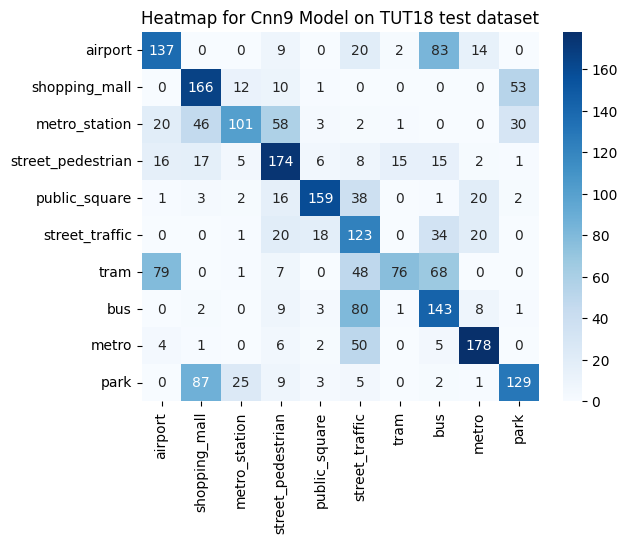

In [79]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(tut_df['labels'], preds)
plt.title('Heatmap for Cnn9 Model on TUT18 test dataset')
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')

In [78]:
from sklearn.metrics import classification_report

print(classification_report(tut_df['labels'], preds))

                   precision    recall  f1-score   support

          airport       0.53      0.52      0.52       265
              bus       0.52      0.69      0.59       242
            metro       0.69      0.39      0.50       261
    metro_station       0.55      0.67      0.60       259
             park       0.82      0.66      0.73       242
    public_square       0.33      0.57      0.42       216
    shopping_mall       0.80      0.27      0.41       279
street_pedestrian       0.41      0.58      0.48       247
   street_traffic       0.73      0.72      0.73       246
             tram       0.60      0.49      0.54       261

         accuracy                           0.55      2518
        macro avg       0.60      0.56      0.55      2518
     weighted avg       0.60      0.55      0.55      2518



In [34]:
scapper_df = pd.read_csv('predictions/ASC_scapper_Cnn9_64mel_10epochs.csv')
scapper_scenes = scapper_df['acoustic_scene_label'].unique()
scapper_scenes

array(['bus', 'busystreet', 'office', 'openairmarket', 'park',
       'quietstreet', 'restaurant', 'supermarket', 'tube', 'tubestation'],
      dtype=object)

In [38]:
SAMPLE_RATE = 32000
WINDOW_SIZE = 1024
HOP_SIZE = 500
MEL_BINS = 64
FMIN = 50
FMAX = 14000

def get_logMel_audio(audio):
    log_mel = audio_utils.get_log_melSpectrogram(
        audio, sample_rate=SAMPLE_RATE, n_mels=MEL_BINS, n_fft=WINDOW_SIZE, hop_len=HOP_SIZE
    )
    return log_mel

def zero_signal(log_mel, index):
    log_mel[0][index] = torch.ones(log_mel[0][index].shape) * log_mel.min()
    return log_mel.to(device)

def run_loop(audio_fname, model):
    feat_inva_output_list = []
    audio = audio_utils.load_audio_from_file(audio_fname, sample_rate=32000)
    input_feats = get_logMel_audio(audio)

    n_features = input_feats.shape[1]

    for i in range(n_features):
        input_feats = get_logMel_audio(audio)
        input_log_mel = zero_signal(input_feats.cpu(), i)

        model.eval()
        with torch.inference_mode():
            predictions = scapper_scenes[make_preds(input_log_mel)]
            #predictions = tut_scenes[torch.argmax(torch.sigmoid(predictions.cpu()))]
        feat_inva_output_list.append(predictions)
    return feat_inva_output_list

In [36]:
true_preds = scapper_df[scapper_df['acoustic_scene_label'] == scapper_df['preds']]

In [17]:
true_preds.head(2)

,audio_fileNames,label_fileNames,acoustic_scene_label,events_label_list,preds
0,bus10_0.wav,bus10_0.jams,bus,"['cough', 'phone', 'keys', 'phone', 'cough', '...",bus
1,bus10_1.wav,bus10_1.jams,bus,"['keys', 'clearthroat', 'laughter', 'keys', 'p...",bus


In [39]:
import random

feat_ablation_preds = {i:[] for i in scapper_scenes}
random_files = []

for i in scapper_scenes:
    random.seed(42)
    random_files.append(random.sample(true_preds[true_preds['acoustic_scene_label'] == i]['audio_fileNames'].tolist(), 20))

for i in range(len(scapper_scenes)):
    for j in random_files[i]:
        feat_ablation_preds[scapper_scenes[i]].append(run_loop(os.path.join(datasets.SCAPPER_AUD_DIR+'test/',j), model))


In [41]:
feat_ablation = {i:[0 for j in range(64)] for i in scapper_scenes}

for i in scapper_scenes:
    for j in range(len(feat_ablation_preds[i])):
        for k in range(len(feat_ablation_preds[i][j])):
            if i != feat_ablation_preds[i][j][k]:
                feat_ablation[i][k] += 1


<Axes: title={'center': 'Feature ablation for Scapper test set using CNN-9 model'}>

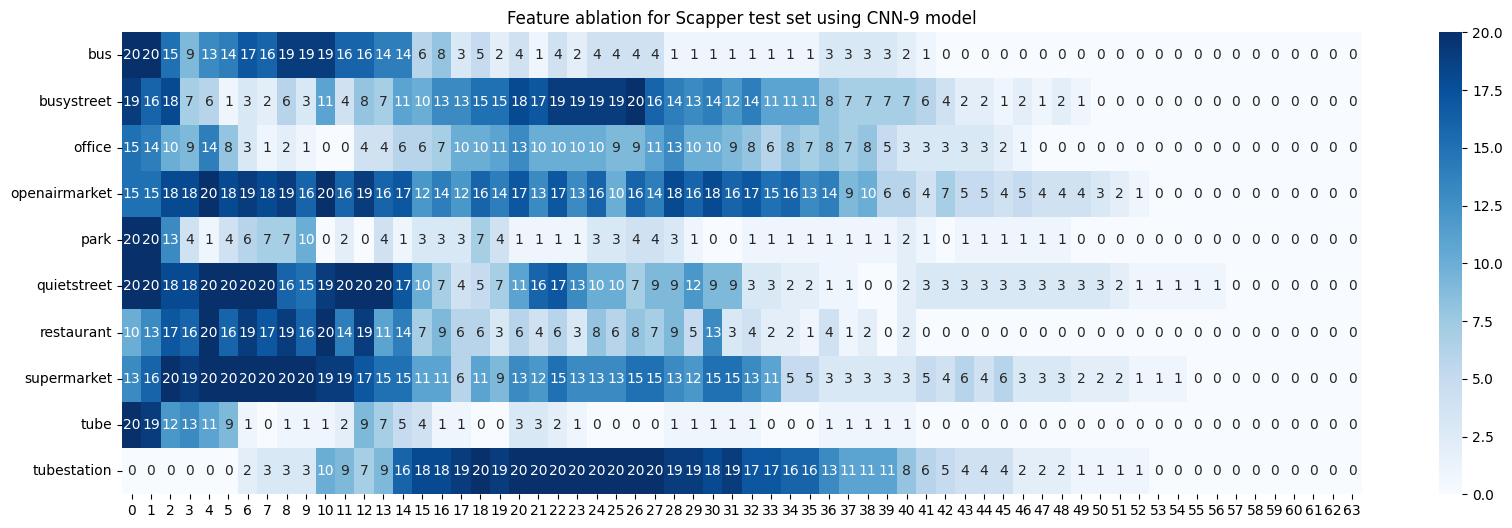

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(20,6))
plt.title('Feature ablation for Scapper test set using CNN-9 model')
sns.heatmap(pd.DataFrame(feat_ablation).transpose(), fmt='d', annot=True, cmap='Blues', yticklabels=scapper_scenes)

<Axes: >

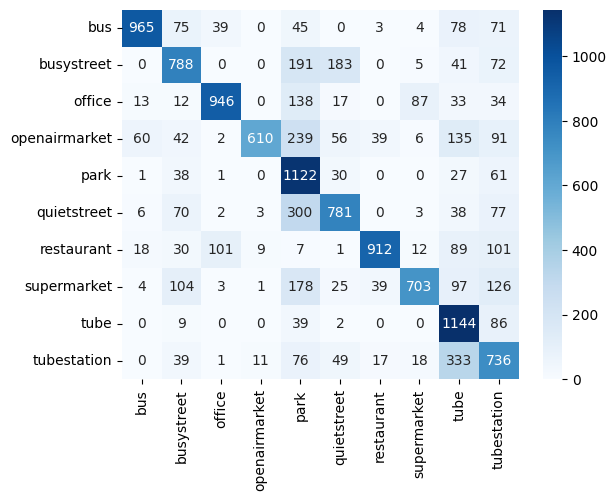

In [43]:
from sklearn.metrics import confusion_matrix

tru = []
preds = []

for i in scapper_scenes:
    for j in range(len(feat_ablation_preds[i])):
        for k in range(len(feat_ablation_preds[i][j])):
            tru.append(i)
            preds.append(feat_ablation_preds[i][j][k])

cm = confusion_matrix(tru, preds)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=scapper_scenes, yticklabels=scapper_scenes, cmap='Blues')

In [73]:
from sklearn.metrics import classification_report

print(classification_report(tut_df['labels'], tut_df['preds'], labels=labels))

                   precision    recall  f1-score   support

          airport       0.53      0.52      0.52       265
    shopping_mall       0.80      0.27      0.41       279
    metro_station       0.55      0.67      0.60       259
street_pedestrian       0.41      0.58      0.48       247
    public_square       0.33      0.57      0.42       216
   street_traffic       0.73      0.72      0.73       246
             tram       0.60      0.49      0.54       261
              bus       0.52      0.69      0.59       242
            metro       0.69      0.39      0.50       261
             park       0.82      0.66      0.73       242

         accuracy                           0.55      2518
        macro avg       0.60      0.56      0.55      2518
     weighted avg       0.60      0.55      0.55      2518

